In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py

from IPython.display import clear_output

In [2]:
import fulu
import utils
from binned_split import binned_train_test_split
from copy import deepcopy

In [3]:
from joblib import Parallel, delayed

In [4]:
import warnings
# warnings.filterwarnings("ignore")

# Read data

In [5]:
data = pd.read_csv('../data/plasticc/good_objects.csv.gz').dropna()

In [6]:
data.head()

,good_objects.csv,object_id,mjd,passband,flux,flux_err,detected_bool,log_lam,class
0,924.0,730.0,60532.3019,2.0,20.994711,1.047298,1.0,3.790512,0.0
1,926.0,730.0,60532.3173,3.0,31.523088,1.569497,1.0,3.875155,0.0
2,927.0,730.0,60532.3282,4.0,41.159981,2.310168,1.0,3.938479,0.0
3,928.0,730.0,60532.3392,5.0,46.795868,5.458707,1.0,3.987288,0.0
4,931.0,730.0,60535.2957,3.0,30.361010,2.107024,1.0,3.875155,0.0


In [7]:
object_ids = np.unique(data.object_id)
print("Number of curves is ", len(object_ids))

Number of curves is  199434


In [8]:
passband2name = {0: 'u', 1: 'g', 2: 'r', 3: 'i', 4: 'z', 5: 'y'}
passband2lam  = {0: np.log10(3751.36), 1: np.log10(4741.64), 2: np.log10(6173.23), 
                 3: np.log10(7501.62), 4: np.log10(8679.19), 5: np.log10(9711.53)}

# Utils

In [9]:
def get_object(data, object_id):
    anobject = data[data.object_id == object_id].copy()
    return anobject

In [10]:
def get_passband(anobject, passband):
    light_curve = anobject[anobject.passband == passband]
    return light_curve

In [11]:
def add_log_lam(anobject):
    passbands = anobject.passband.values
    log_lam = [passband2lam[i] for i in passbands]
    anobject.loc[:, 'log_lam'] = log_lam
    return anobject

In [12]:
def is_good(anobject):
    good = 1
    
    # remove all objects with negative flux values
    if anobject['flux'].values.min() < 0:
        good = 0
    
    # keep only objects with at least 7 observations in at least 3 passbands
    count = 0
    for passband in range(6):
        if len(get_passband(anobject, passband)) < 7:
            count += 1
    if count > 3:
        good = 0
        
    # keep only objects without large breaks in observations
    anobject = anobject.sort_values('mjd')
    mjd = anobject['mjd'].values
    if np.diff(mjd, 1).max() > 50:
        good = 0
    
    return good

# Visualization

In [13]:
def plot_light_curves(anobject, title="", is_plot=True):
    anobject = anobject.sort_values('mjd')
    plt.figure(figsize=(9, 5.5))
    for passband in range(len(passband2name)):
        light_curve = get_passband(anobject, passband)
        if is_plot:
            plt.plot(light_curve['mjd'].values, light_curve['flux'].values, linewidth=0.5)
        plt.scatter(light_curve['mjd'].values, light_curve['flux'].values, label=passband2name[passband], linewidth=1)
    plt.xlabel('Modified Julian Date', size=20)
    plt.xticks(size=18)
    plt.ylabel('Flux', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=3, fontsize=18)
    plt.title(title, size=18)

In [14]:
def plot_light_curves_with_sigma(t, flux, flux_err, passband, title=""):
    colors = ['C'+str(i) for i in range(len(np.unique(passband)))]
    plt.figure(figsize=(9, 4))
    for i, pb in enumerate(np.unique(passband)):
        plt.plot(t[passband == pb], flux[passband == pb], linewidth=2., color=colors[i])
        plt.fill_between(t[passband == pb], 
                         flux[passband == pb]+1*flux_err[passband == pb], 
                         flux[passband == pb]-1*flux_err[passband == pb], label=passband2name[pb], alpha=0.5, color=colors[i])
    plt.xlabel('Time', size=14)
    plt.xticks(size=14)
    plt.ylabel('Flux', size=14)
    plt.yticks(size=14)
    plt.legend(loc='best', ncol=3, fontsize=14)
    plt.title(title, size=14)

13.0


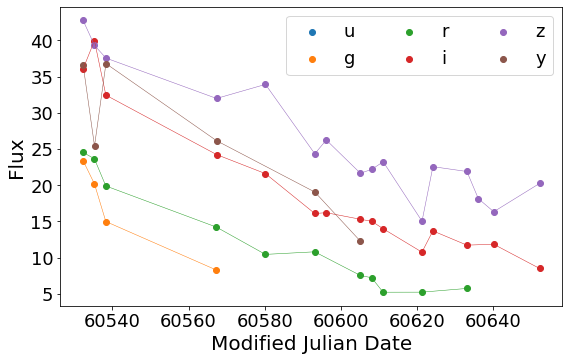

88.0


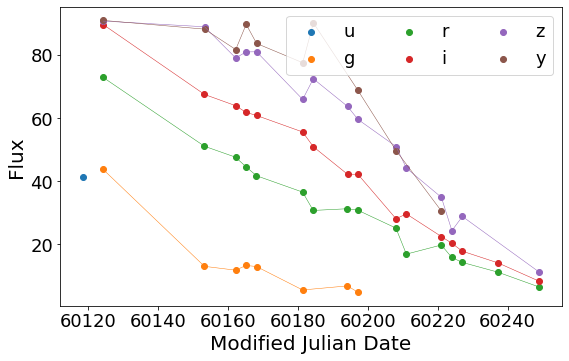

96.0


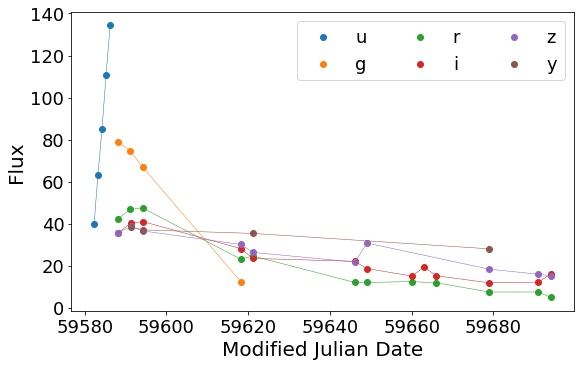

176.0


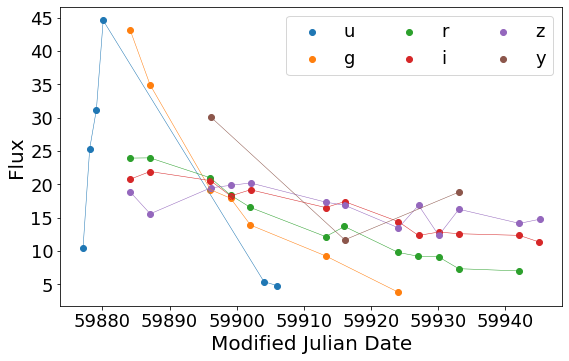

195.0


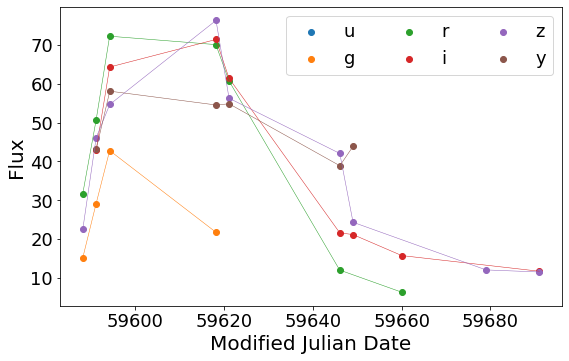

198.0


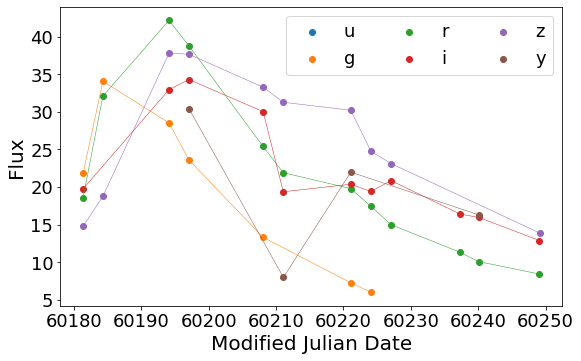

In [15]:
for i in object_ids[:20]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

# One object test

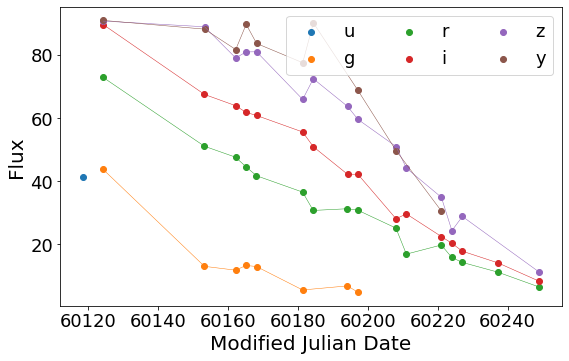

In [16]:
anobject = get_object(data, 88)
anobject = add_log_lam(anobject)

plot_light_curves(anobject)
# plt.savefig('light_curve_34299.pdf', format='pdf')

RMSE:  3.5205430143306065
MAE:  3.153371579519426
RSE:  0.13440400638300837
RAE:  0.14004502619466425
MAPE:  13.164195734833566
NLPD:  2.7910661153430065
nRMSEo:  2.4632934416303542
nRMSEp:  0.6704875390036353
PICP@68:  0.8947368421052632
PICP@95:  1.0


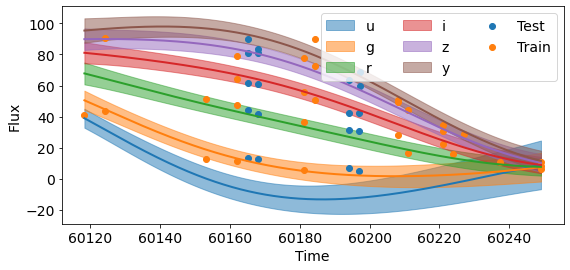

In [17]:
N = 30

# train test split
t = anobject['mjd'].values
anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                        t=t, 
                                                        bin_size=5, 
                                                        test_size=2, 
                                                        shuffle=True, 
                                                        random_state=11, 
                                                        bounds_in_train=True)

t_train = anobject_train['mjd'].values
i_min = t_train.argmin()
i_max = t_train.argmax()
edges = np.array([i_min, i_max])

mask = np.arange(len(anobject_train))
mask = mask[~np.in1d(mask, edges)]

if len(mask) < N-2:
    raise Exception("Number of observation in train is smaller than %d" % (N))
elif N is not None:
    mask = np.random.RandomState(22).choice(mask, N-2, replace=False)
    mask = np.concatenate((mask, edges))



t_train = anobject_train['mjd'].values[mask]
flux_train = anobject_train['flux'].values[mask]
flux_err_train = anobject_train['flux_err'].values[mask]
passband_train = anobject_train['passband'].values[mask]

t_test = anobject_test['mjd'].values
flux_test = anobject_test['flux'].values
flux_err_test = anobject_test['flux_err'].values
passband_test = anobject_test['passband'].values

# approximation model
aug = fulu.GaussianProcessesAugmentation(passband2lam)
aug.fit(t_train, flux_train, flux_err_train, passband_train)

# augmentation
t_aug, flux_aug, flux_err_aug, passband_aug= aug.augmentation(t_min=t.min(), t_max=t.max(), n_obs=1000)

# plotting
plot_light_curves_with_sigma(t_aug, flux_aug, flux_err_aug, passband_aug, title="")
plt.scatter(t_test, flux_test, label='Test')
plt.scatter(t_train, flux_train, label='Train')
plt.legend(loc='best', ncol=3, fontsize=14)

# calculate quality metrics
flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
[rmse, mae, rse, rae, mape, nlpd, nrmseo, nrmsep, picp_68, picp_95] = utils.regression_quality_metrics_report(flux_test, flux_pred_test, 
                                                                                                              flux_err_test, flux_err_pred_test)
print("RMSE: ", rmse)
print("MAE: ", mae)
print("RSE: ", rse)
print("RAE: ", rae)
print("MAPE: ", mape)
print("NLPD: ", nlpd)
print("nRMSEo: ", nrmseo)
print("nRMSEp: ", nrmsep)
print("PICP@68: ", picp_68)
print("PICP@95: ", picp_95)

# Test on many objects

In [18]:
def gen_report(metrics, silent=False):
    report = pd.DataFrame(columns=["ID", 'RMSE', 'MAE', 'RSE', 'RAE', 'MAPE', 'NLPD', 'nRMSEo', 'nRMSEp', 'PICP_68', 'PICP_95'])
    for i, met in enumerate(metrics):
        if met is not None:
            report.loc[len(report), :] = [i] + list(met)
    n_failed = report[report.MAE == -999].shape[0]
    if not silent: print("Num. of failed curves: ", n_failed)
    report = report[report.MAE != -999]
    return report

In [19]:
from sklearn.utils import resample

def bootstrap_metrics(metrics, n_iters=1000):
    means = []
    header = metrics.columns
    inds = np.arange(len(metrics))
    for i in range(n_iters):
        inds_boot = resample(inds)
        metrics_boot = metrics.iloc[inds_boot]
        means.append(metrics_boot.mean(axis=0))
    means = np.array(means)
    mu = np.round(means.mean(axis=0), 3)
    sigma = np.round(means.std(axis=0), 3)
    df = pd.DataFrame(columns=header, data=[mu, sigma], index=['mean', 'std'])
    return df

In [20]:
from sklearn.gaussian_process.kernels import RBF, Matern, RationalQuadratic, WhiteKernel, ConstantKernel as C

In [21]:
def one_object_run(i, N=None):
    
    warnings.filterwarnings("ignore")
    
    # get an object
    anobject = get_object(data, i)
    anobject = add_log_lam(anobject)
    
    # take only good curves
    try:
        if not is_good(anobject): 
            return None
    except:
        print(i, len(anobject), t.max()-t.min())
        return [-999] * 10
    
    # train test split
    t = anobject['mjd'].values
    try:
        anobject_train, anobject_test = binned_train_test_split(anobject, 
                                                            t=t, 
                                                            bin_size=5, 
                                                            test_size=2, 
                                                            shuffle=True, 
                                                            random_state=11, 
                                                            bounds_in_train=True)
    
    except:
        print(i, len(anobject), t.max()-t.min())
        return [-999] * 10
    
    t_train = anobject_train['mjd'].values
    i_min = t_train.argmin()
    i_max = t_train.argmax()
    edges = np.array([i_min, i_max])

    mask = np.arange(len(anobject_train))
    mask = mask[~np.in1d(mask, edges)]

    if len(mask) < N-2 or N <= 2:
        return [-999] * 10
    elif N is not None:
        mask = np.random.RandomState(22).choice(mask, N-2, replace=False)
        mask = np.concatenate((mask, edges))

    t_train = anobject_train['mjd'].values[mask]
    flux_train = anobject_train['flux'].values[mask]
    flux_err_train = anobject_train['flux_err'].values[mask]
    passband_train = anobject_train['passband'].values[mask]

    t_test = anobject_test['mjd'].values
    flux_test = anobject_test['flux'].values
    flux_err_test = anobject_test['flux_err'].values
    passband_test = anobject_test['passband'].values
    
    # approximation model
    if MODEL == "GP":
        aug = fulu.GaussianProcessesAugmentation(**params)
    elif MODEL == "NN_sklearn":
        aug = fulu.MLPRegressionAugmentation(**params)
    elif MODEL == "NN_pytorch":
        aug = fulu.SingleLayerNetAugmentation(**params)
    elif MODEL == "BNN":
        aug = fulu.BayesianNetAugmentation(**params)
    elif MODEL == "NF":
        aug = fulu.NormalizingFlowAugmentation(**params)

    # fit the model
    aug.fit(t_train, flux_train, flux_err_train, passband_train)

    # calculate quality metrics
    flux_pred_test, flux_err_pred_test = aug.predict(t_test, passband_test)
    metrics = utils.regression_quality_metrics_report(flux_test, flux_pred_test, flux_err_test, flux_err_pred_test)
    
    return metrics

In [22]:
# ms = []
# for i in object_ids[-10:]:
#     print(i)
#     m = one_object_run(i, 5)
#     ms.append(m)

In [23]:
%%time

MODEL = "GP"
params = {'passband2lam': passband2lam, 
          'kernel': C(1.0) * Matern([1, 1]) + WhiteKernel()
         }
metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, 5) for i in object_ids)
report_gp = gen_report(metrics)
bootstrap_metrics(report_gp)

Num. of failed curves:  14
CPU times: user 2min 23s, sys: 3.14 s, total: 2min 26s
Wall time: 4min 40s


,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
mean,61038.963,252.293,221.952,4.859,4.764,78.207,1079.122,24.867,6.730,0.413,0.644
std,637.927,20.934,18.113,1.739,1.735,1.471,358.676,0.516,0.446,0.003,0.003


In [24]:
np.arange(6, 61, 2)

array([ 6,  8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38,
       40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60])

In [25]:
np.arange(10, 61, 10)

array([10, 20, 30, 40, 50, 60])

In [26]:
%%time

Ns = np.arange(6, 61, 2)


mape_mu_gp = []
mape_s_gp  = [] 

for n in Ns:
    
    
    if n%10 == 0:
        print("Status: %d observations" % (n))
    
    MODEL = "GP"
    params = {'passband2lam': passband2lam, 
              'kernel': C(1.0) * Matern([1, 1]) + WhiteKernel()
             }
    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, n) for i in object_ids)
    report = gen_report(metrics, silent=True)
    report = report[report['MAPE'] < 500]
    print("report size: ", len(report))
    report = bootstrap_metrics(report)
    mape_mu_gp.append(report.loc['mean', 'MAPE'])
    mape_s_gp.append(report.loc['std', 'MAPE'])
    

report size:  10642
report size:  10659
Status: 10 observations
report size:  10670
report size:  10690
report size:  10681
report size:  10645
report size:  10585
Status: 20 observations
report size:  10429
report size:  10158
report size:  9672
report size:  8964
report size:  7963
Status: 30 observations
report size:  6787
report size:  5579
report size:  4530
report size:  3671
report size:  2930
Status: 40 observations
report size:  2406
report size:  2003
report size:  1662
report size:  1440
report size:  1233
Status: 50 observations
report size:  1062
report size:  926
report size:  823
report size:  714
report size:  606
Status: 60 observations
report size:  518
CPU times: user 1h 6min 46s, sys: 1min 26s, total: 1h 8min 13s
Wall time: 1h 59min 2s


In [27]:
%%time

mape_mu_sk = []
mape_s_sk  = [] 

for n in Ns:
    
    if n%10 == 0:
        print("Status: %d observations" % (n))
    
    MODEL = "NN_sklearn"    
    params = {'passband2lam': passband2lam, 
              'hidden_layer_sizes': (20, 20),
              'solver': 'lbfgs',
              'activation': 'tanh',
              'learning_rate_init': 0.1,
              'max_iter': 900,
              'batch_size': 500, 
              'weight_decay': 0.1}
    
    metrics   = Parallel(n_jobs=-1)(delayed(one_object_run)(i, n) for i in object_ids)
    report = gen_report(metrics, silent=True)
    report = report[report['MAPE'] < 500]
    print("report size: ", len(report))
    report = bootstrap_metrics(report)
    mape_mu_sk.append(report.loc['mean', 'MAPE'])
    mape_s_sk.append(report.loc['std', 'MAPE'])
    

report size:  10646
report size:  10650
Status: 10 observations
report size:  10667
report size:  10677
report size:  10681
report size:  10643
report size:  10580
Status: 20 observations
report size:  10427
report size:  10155
report size:  9667
report size:  8963
report size:  7962
Status: 30 observations
report size:  6792
report size:  5584
report size:  4534
report size:  3671
report size:  2931
Status: 40 observations
report size:  2407
report size:  2004
report size:  1663
report size:  1441
report size:  1234
Status: 50 observations
report size:  1063
report size:  927
report size:  823
report size:  715
report size:  606
Status: 60 observations
report size:  518
CPU times: user 1h 4min 54s, sys: 1min 26s, total: 1h 6min 21s
Wall time: 1h 57min 24s


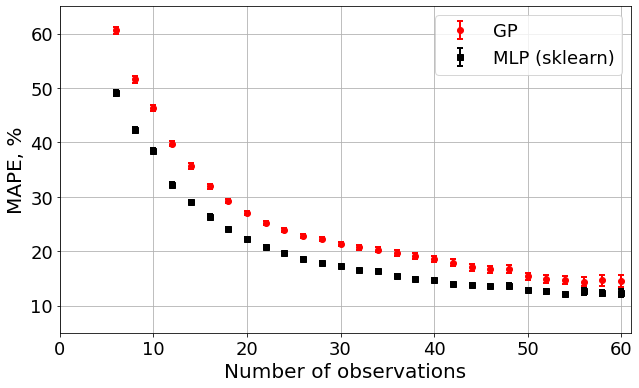

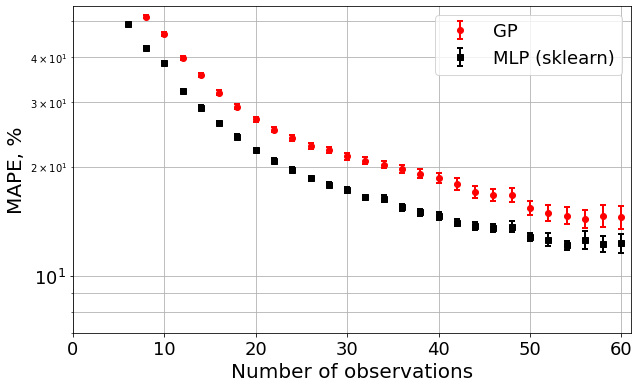

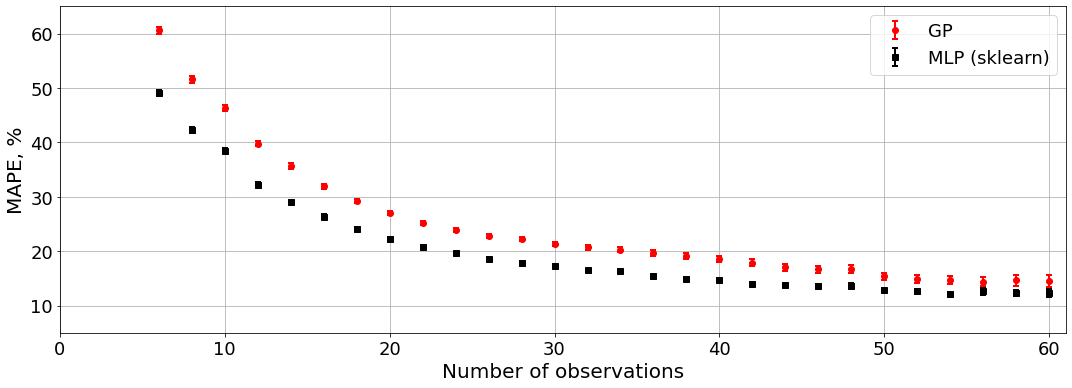

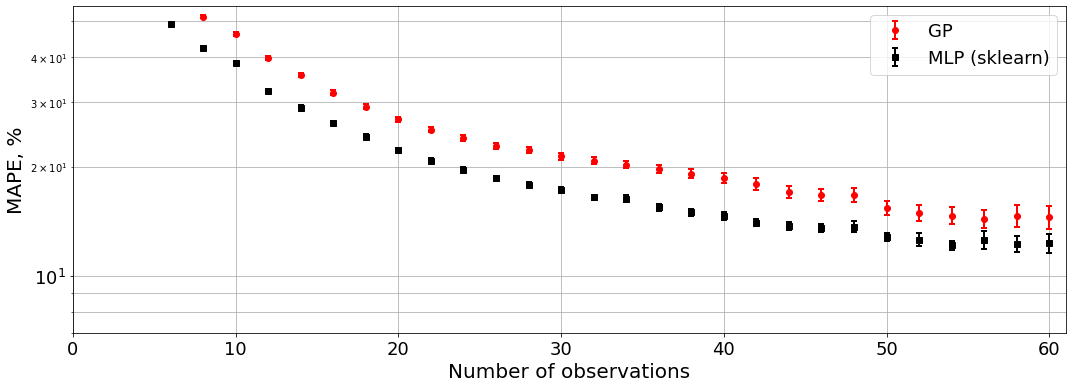

In [36]:
for mark in ['lin', 'log', '15', '15log']:

    if mark == '15' or mark == '15log':
        plt.figure(figsize=(15, 5.5))
    else:
        plt.figure(figsize=(9, 5.5))
    plt.errorbar(Ns, mape_mu_gp, yerr=mape_s_gp, fmt='o', ms=6, color='red', elinewidth=2, capsize=3, capthick=2, ecolor='red', label="GP")
    plt.errorbar(Ns, mape_mu_sk, yerr=mape_s_sk, fmt='s', ms=6, color='0', elinewidth=2, capsize=3, capthick=2, ecolor='0', label="MLP (sklearn)")
    plt.xlim(0, 61)
    plt.ylim(5, 65)
    plt.xlabel('Number of observations', size=20)
    plt.xticks(size=18)
    plt.ylabel('MAPE, %', size=20)
    plt.yticks(size=18)
    plt.legend(loc='best', ncol=1, fontsize=18)
    if mark == 'log' or mark == '15log':
        plt.yscale('log')
        plt.grid(which='minor', axis='y')
        plt.ylim(7, 55)
    plt.grid()
    plt.tight_layout()
    plt.savefig('img/mape_vs_nobs_plasticc_%s.pdf' % (mark), format='pdf')
    plt.savefig('img/mape_vs_nobs_plasticc_%s.png' % (mark), format='png')
    plt.show()

In [29]:
n = []
for i in object_ids:
    anobject = get_object(data, i)
    n.append(len(anobject))
n = np.array(n)

69490.0 28 48.86740000000282
246083.0 23 48.86740000000282
238657.0 28 48.86740000000282
238657.0 28 48.86740000000282
315247.0 24 28.862800000002608
310880.0 30 48.86740000000282
71825.0 25 48.86740000000282
315247.0 24 28.862800000002608
246083.0 23 48.86740000000282
310880.0 30 48.86740000000282
35149.0 28 48.86740000000282
35149.0 28 48.86740000000282
69490.0 28 48.86740000000282
238657.0 28 48.86740000000282
137083.0 25 45.96860000000015
196865.0 29 48.86740000000282
184815.0 27 48.87830000000395
218682.0 31 48.86740000000282
238657.0 28 48.86740000000282
246083.0 23 48.86740000000282
159091.0 26 48.86740000000282
246083.0 23 48.86740000000282
159091.0 26 48.86740000000282
238657.0 28 48.86740000000282
218682.0 31 48.86740000000282
159091.0 26 48.86740000000282
315247.0 24 28.862800000002608
69490.0 28 48.86740000000282
315247.0 24 28.862800000002608
69490.0 28 48.86740000000282
137083.0 25 45.96860000000015
159091.0 26 48.86740000000282
196865.0 29 48.86740000000282
273938.0 27 4

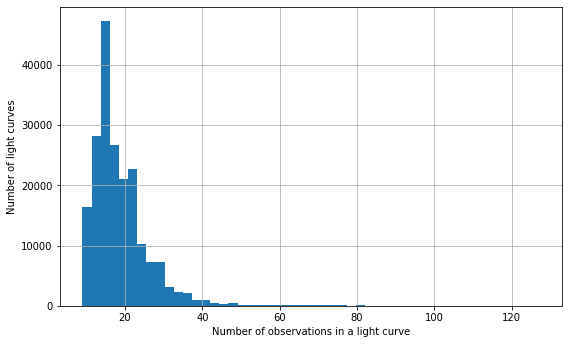

In [30]:
plt.figure(figsize=(9, 5.5))
plt.hist(n[n<300], bins=50)
plt.xlabel('Number of observations in a light curve')
plt.ylabel('Number of light curves')
plt.grid()
plt.show()

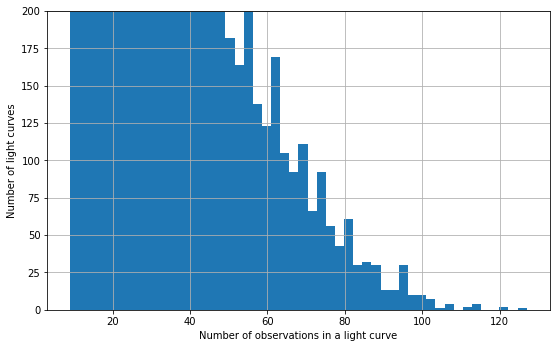

In [31]:
plt.figure(figsize=(9, 5.5))
plt.hist(n[n<300], bins=50)
plt.xlabel('Number of observations in a light curve')
plt.ylabel('Number of light curves')
plt.ylim(0, 200)
plt.grid()
plt.show()

10321.0


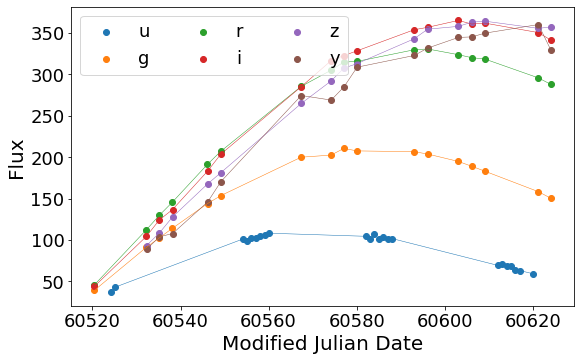

20934.0


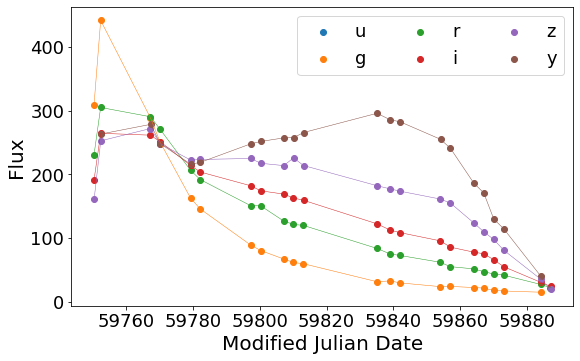

23539.0


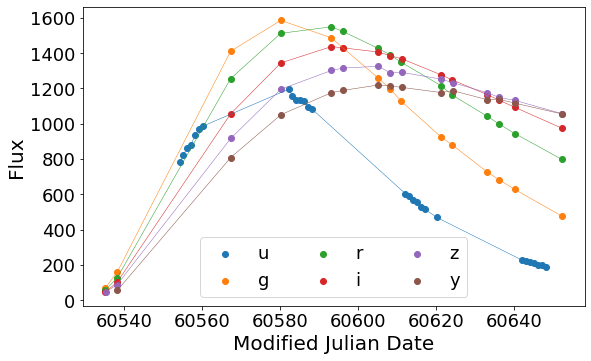

29167.0


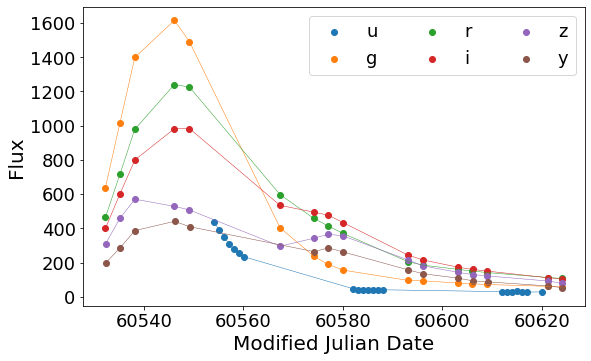

40259.0


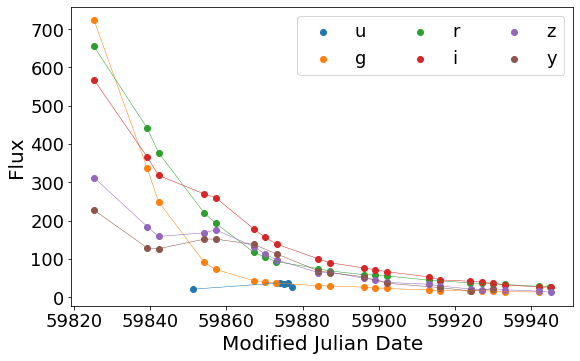

42469.0


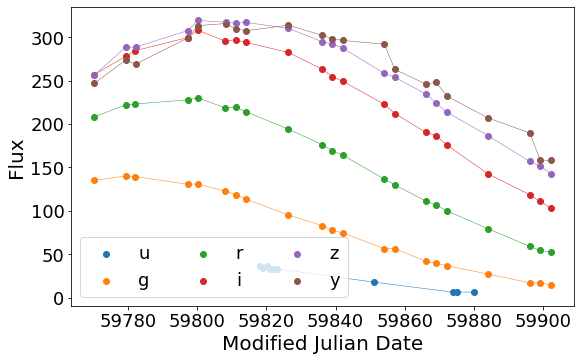

78727.0


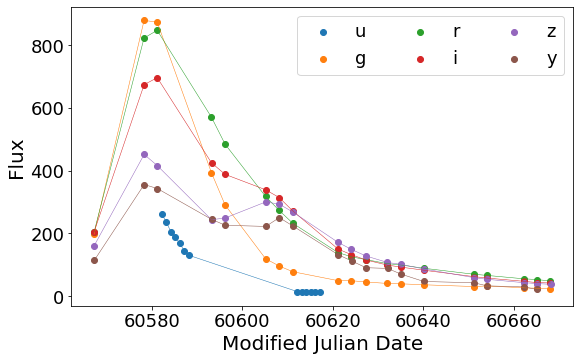

103162.0


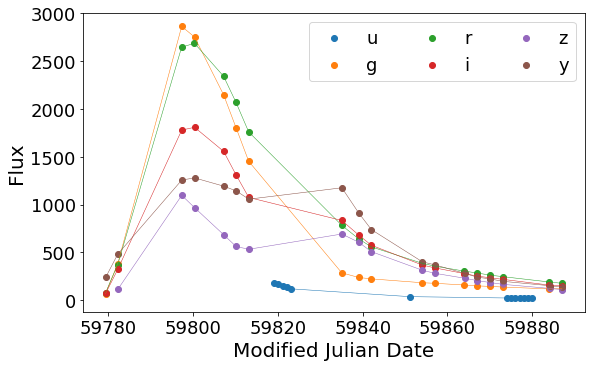

109516.0


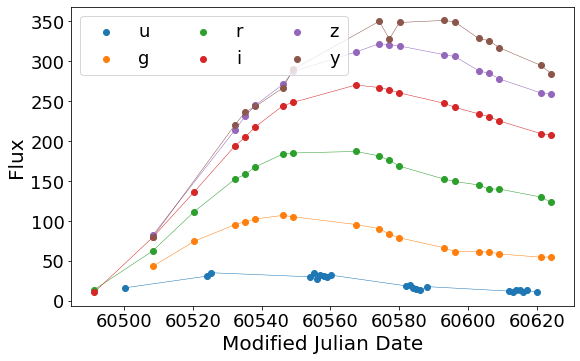

113836.0


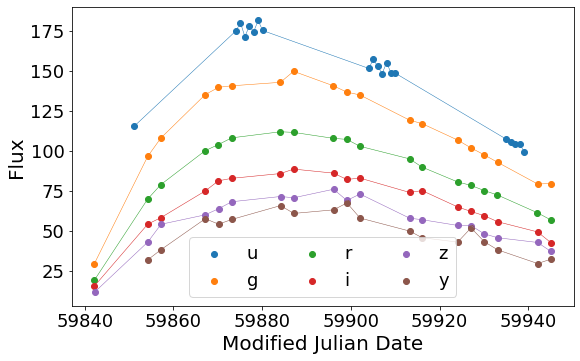

In [32]:
for i in object_ids[:5000]:
    anobject = get_object(data, i)
    if not is_good(anobject):
        continue
    if len(anobject) < 100:
        continue
    print(i)
    plot_light_curves(anobject)
    plt.show()

In [33]:
report = gen_report(metrics, silent=True)

In [34]:
report

,ID,RMSE,MAE,RSE,RAE,MAPE,NLPD,nRMSEo,nRMSEp,PICP_68,PICP_95
31,73,6.332311,4.184314,0.207443,0.153006,13.648742,3.583113,2.702595,1.608678,0.625,0.75
54,150,2.55416,2.252356,0.084914,0.082431,8.764012,2.389887,1.193396,0.82361,0.714286,1.0
58,165,217.680588,172.663021,0.195644,0.173318,62.613419,7.061783,30.922278,0.541659,0.857143,1.0
61,170,3.081012,2.33153,0.077919,0.070571,4.167316,2.570499,1.22061,1.166334,0.642857,0.928571
67,182,3.887071,3.051484,0.109225,0.100585,6.853755,2.849569,2.454725,0.743181,0.866667,1.0
...,...,...,...,...,...,...,...,...,...,...,...
4811,12813,3.120485,2.121847,0.231471,0.179033,11.055679,2.558885,1.347659,0.956082,0.769231,0.923077
4816,12834,3.525299,2.541882,0.411851,0.364116,8.369199,3.091511,1.290987,1.698412,0.666667,0.833333
4827,12889,2.076797,1.719311,0.13641,0.13213,5.4483,2.150191,1.528851,1.0207,0.666667,0.916667
4836,12912,4.435405,3.296975,0.172164,0.148675,7.148777,2.91655,2.180322,1.090695,0.7,0.9
